In [29]:
!gdown https://drive.google.com/drive/folders/1CIg84uv3_Br49iF-HA-lihRnNEX_IVBR --folder
!gdown https://drive.google.com/drive/folders/1zFD70aYnQvlyvm1A-EuMSY7tSSj-BKxJ --folder


!pip install nflows

Retrieving folder contents
Processing file 17LdtNKkpOEpk-l_EKX4BwtGUm0ML6vmT dataset_piccolo.txt
Processing file 1WC-TS1pel_lUT7bPenVyDXKEQjxjAmlg dataset.txt
Processing file 1XjcRDOZVJV-I6gadgYwebf1Woi08eIEL test_dataset.txt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=17LdtNKkpOEpk-l_EKX4BwtGUm0ML6vmT
To: /content/data/dataset_piccolo.txt
100% 78.9M/78.9M [00:01<00:00, 65.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1WC-TS1pel_lUT7bPenVyDXKEQjxjAmlg
From (redirected): https://drive.google.com/uc?id=1WC-TS1pel_lUT7bPenVyDXKEQjxjAmlg&confirm=t&uuid=8529a4be-a4cc-4df2-aac0-9410b5d9214e
To: /content/data/dataset.txt
100% 153M/153M [00:01<00:00, 93.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1XjcRDOZVJV-I6gadgYwebf1Woi08eIEL
From (redirected): https://drive.google.com/uc?id=1XjcRDOZVJV-I6gadgYwebf1Woi08eIEL&confirm=t&uuid=b5c4a1

In [30]:
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.base import InverseTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.transforms.permutations import RandomPermutation

from torch import optim
from torchsummary import summary
from torchvision import models

import torch
from sklearn import preprocessing
from utils.model import model_definer
from utils.our_classes import Compressor
from utils.our_classes import Preprocessor

import scipy.special
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
from os import stat
import sys

labels_map = {
    0: "$p_T$",
    1: "$\eta$",
    2: "$\phi$",
    3: "mass",
    4: "JetArea",
    5: "ChargedHadronEnergy",
    6: "NeutralHadronEnergy",
    7: "PhotonEnergy",
    8: "ElectronEnergy",
    9: "MuonEnergy",
    10: "HFHadronHadronEnergy",
    11: "HFEMEnergy",
    12: "ChargedHadronMultiplicity",
    13: "NeutralHadronMultiplicity",
    14: "PhotonMultiplicity",
    15: "ElectronMultiplicity",
    16: "MuonMultiplicity",
    17: "HFHadronMultiplicity",
    18: "HFEMMultiplicity",
    19: "ChargedEmEnergy",
    20: "ChargedMuEnergy",
    21: "NeutralEmEnergy",
    22: "ChargedMultiplicity",
    23: "NeutralMultiplicity",
}
unit_measure = {
    0: "GeV",
    1: "arb.",
    2: "rad.",
    3: "GeV",
    4: "",
    5: "GeV",
    6: "GeV",
    7: "GeV",
    8: "GeV",
    9: "GeV",
    10: "GeV",
    11: "GeV",
    12: "",
    13: "",
    14: "",
    15: "",
    16: "",
    17: "",
    18: "",
    19: "GeV",
    20: "GeV",
    21: "GeV",
    22: "",
    23: "",
}
num_features = len(labels_map)

index_int = np.append(np.arange(12,19),[22,23])
index_float = np.append(np.arange(0,12),np.arange(19,22))

In [31]:
x = np.loadtxt("data/dataset_piccolo.txt", delimiter=',')
xval = np.loadtxt("data/dataset.txt", delimiter=',')
xtest = np.loadtxt("data/test_dataset.txt", delimiter=',')

L=len(x)
print(L)

472827


In [32]:
###LOG SU 0 E 3,STD SU TUTTE E QUATTRO LE FEATURES E QUANTILE SU 1,2

x = x[:int(L/8),:] #da mettere al massimo a 8 in colab
xval = xval[:len(x),:]
xtest = xtest[:len(x),:]

num_features = 4
x = x[:,0:num_features]
xval = xval[:,0:num_features]
xtest = xtest[:,0:num_features]

print('Eventi =',len(x))
print('attribute\tvalue\ttype\n')
for i in range(0,num_features,1):
  print('{0}\t{1}\t{2}\n'.format(labels_map[i],x[100,i],type(x[100,i])))


preprocessor_settings = {'index_log':([0,3]), 'range_quantile':([1,2]), 'n_quantiles':10000}

x_preprocessor = Preprocessor(preprocessor_settings)
xval_preprocessor = Preprocessor(preprocessor_settings)

xtr = x_preprocessor.forward(x)
xtrval = xval_preprocessor.forward(xval)

xt = torch.tensor(xtr).to('cuda').float()
xval = torch.tensor(xtrval).to('cuda').float()

Eventi = 59103
attribute	value	type

$p_T$	15.8641204834	<class 'numpy.float64'>

$\eta$	-2.97655129433	<class 'numpy.float64'>

$\phi$	-1.19218158722	<class 'numpy.float64'>

mass	4.52637481689	<class 'numpy.float64'>



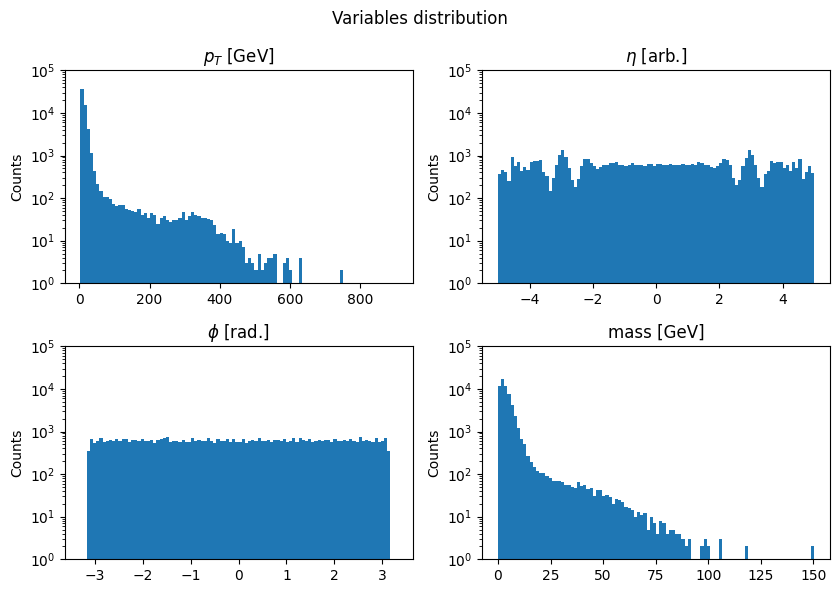

mkdir: cannot create directory ‘figures’: File exists


In [33]:
fig,axs = plt.subplots(2, 2,figsize=(8.5,6))
fig.suptitle("Variables distribution")
n_bins = 100

axs[0, 0].hist(x[:,0],bins=n_bins)
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].set_title('{} [GeV]'.format(labels_map[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].set_ylim(1,10e4)

axs[0, 1].hist(x[:,1],bins=n_bins, range=(-5,5))
axs[0, 1].set_title('{} [arb.]'.format(labels_map[1]))
axs[0, 1].set_ylim(1,10e4)

axs[1, 0].hist(x[:,2],bins=n_bins, range=(-3.30,3.30))
axs[1, 0].set_title('{} [rad.]'.format(labels_map[2]))
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:,3],bins=n_bins)
axs[1, 1].set_title('{} [GeV]'.format(labels_map[3]))
axs[1,1].sharey(axs[0,0])

for ax in axs.flat:
    ax.set(ylabel='Counts',yscale='log')

fig.tight_layout()

plt.show()
!mkdir figures
fig.savefig('figures/Variables_distribution.pdf',dpi=190)

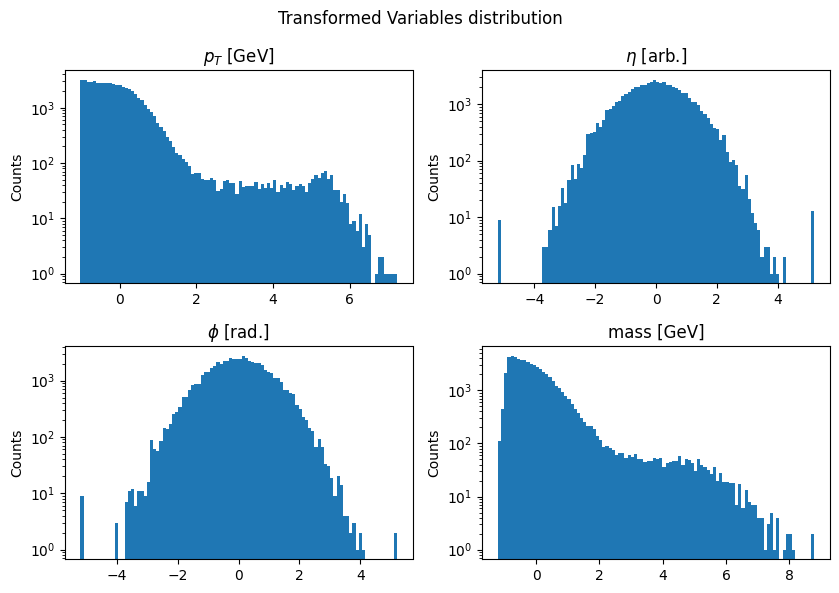

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(8.5, 6))
fig.suptitle("Transformed Variables distribution")
n_bins = 100

axs[0, 0].hist(xtr[:, 0], bins=n_bins,log=True)
axs[0, 0].set_title('{} [GeV]'.format(labels_map[0]))
axs[0, 0].set_ylabel("Counts")

axs[0, 1].hist(xtr[:, 1], bins=n_bins,log=True)
axs[0, 1].set_title('{} [arb.]'.format(labels_map[1]))
axs[0, 1].set_ylabel("Counts")

axs[1, 0].hist(xtr[:, 2], bins=n_bins,log=True)
axs[1, 0].set_title('{} [rad.]'.format(labels_map[2]))
axs[1, 0].set_ylabel("Counts")

axs[1, 1].hist(xtr[:, 3], bins=n_bins,log=True)
axs[1, 1].set_title('{} [GeV]'.format(labels_map[3]))
axs[1, 1].set_ylabel("Counts")

plt.tight_layout()
plt.show()

fig.savefig('figures/Variables_distribution_transformed.pdf',dpi=190)

In [35]:

###Model Optimization
range_iterations = ([2, 4, 6, 8])
range_hidden_features = ([16, 32, 64, 128, 256])
#range_iterations = np.linspace(2,6,5,dtype=int)
#range_hidden_features = np.linspace(32,256,6,dtype=int)

epochs = 100 #andrà messo a 10000 su colab

loss_storer = np.zeros(shape=(len(range_iterations),len(range_hidden_features),epochs))
loss_storer_val = np.zeros(shape=(len(range_iterations),len(range_hidden_features),epochs))

for j in range(len(range_iterations)):
  it = range_iterations[j]
  for k in range(len(range_hidden_features)):
    hf = range_hidden_features[k]
    flow_opt, optimizer_opt = model_definer(num_features=num_features, num_iterations=it, hidden_features=hf)

    for i in range(epochs):
      optimizer_opt.zero_grad()
      loss_opt = -flow_opt.log_prob(inputs=xt).mean()
      loss_opt_val = -flow_opt.log_prob(inputs=xval).mean()
      loss_opt.backward()
      optimizer_opt.step()
      loss_storer[j,k,i] = loss_opt.cpu().detach().numpy()
      loss_storer_val[j,k,i] = loss_opt_val.cpu().detach().numpy()


Num. iterations = 2, Num. hidden_features = 16, Num. trainable parameters = 2608
Num. iterations = 2, Num. hidden_features = 32, Num. trainable parameters = 9296
Num. iterations = 2, Num. hidden_features = 64, Num. trainable parameters = 34960
Num. iterations = 2, Num. hidden_features = 128, Num. trainable parameters = 135440
Num. iterations = 2, Num. hidden_features = 256, Num. trainable parameters = 533008
Num. iterations = 4, Num. hidden_features = 16, Num. trainable parameters = 5216
Num. iterations = 4, Num. hidden_features = 32, Num. trainable parameters = 18592
Num. iterations = 4, Num. hidden_features = 64, Num. trainable parameters = 69920
Num. iterations = 4, Num. hidden_features = 128, Num. trainable parameters = 270880
Num. iterations = 4, Num. hidden_features = 256, Num. trainable parameters = 1066016
Num. iterations = 6, Num. hidden_features = 16, Num. trainable parameters = 7824
Num. iterations = 6, Num. hidden_features = 32, Num. trainable parameters = 27888
Num. iterat

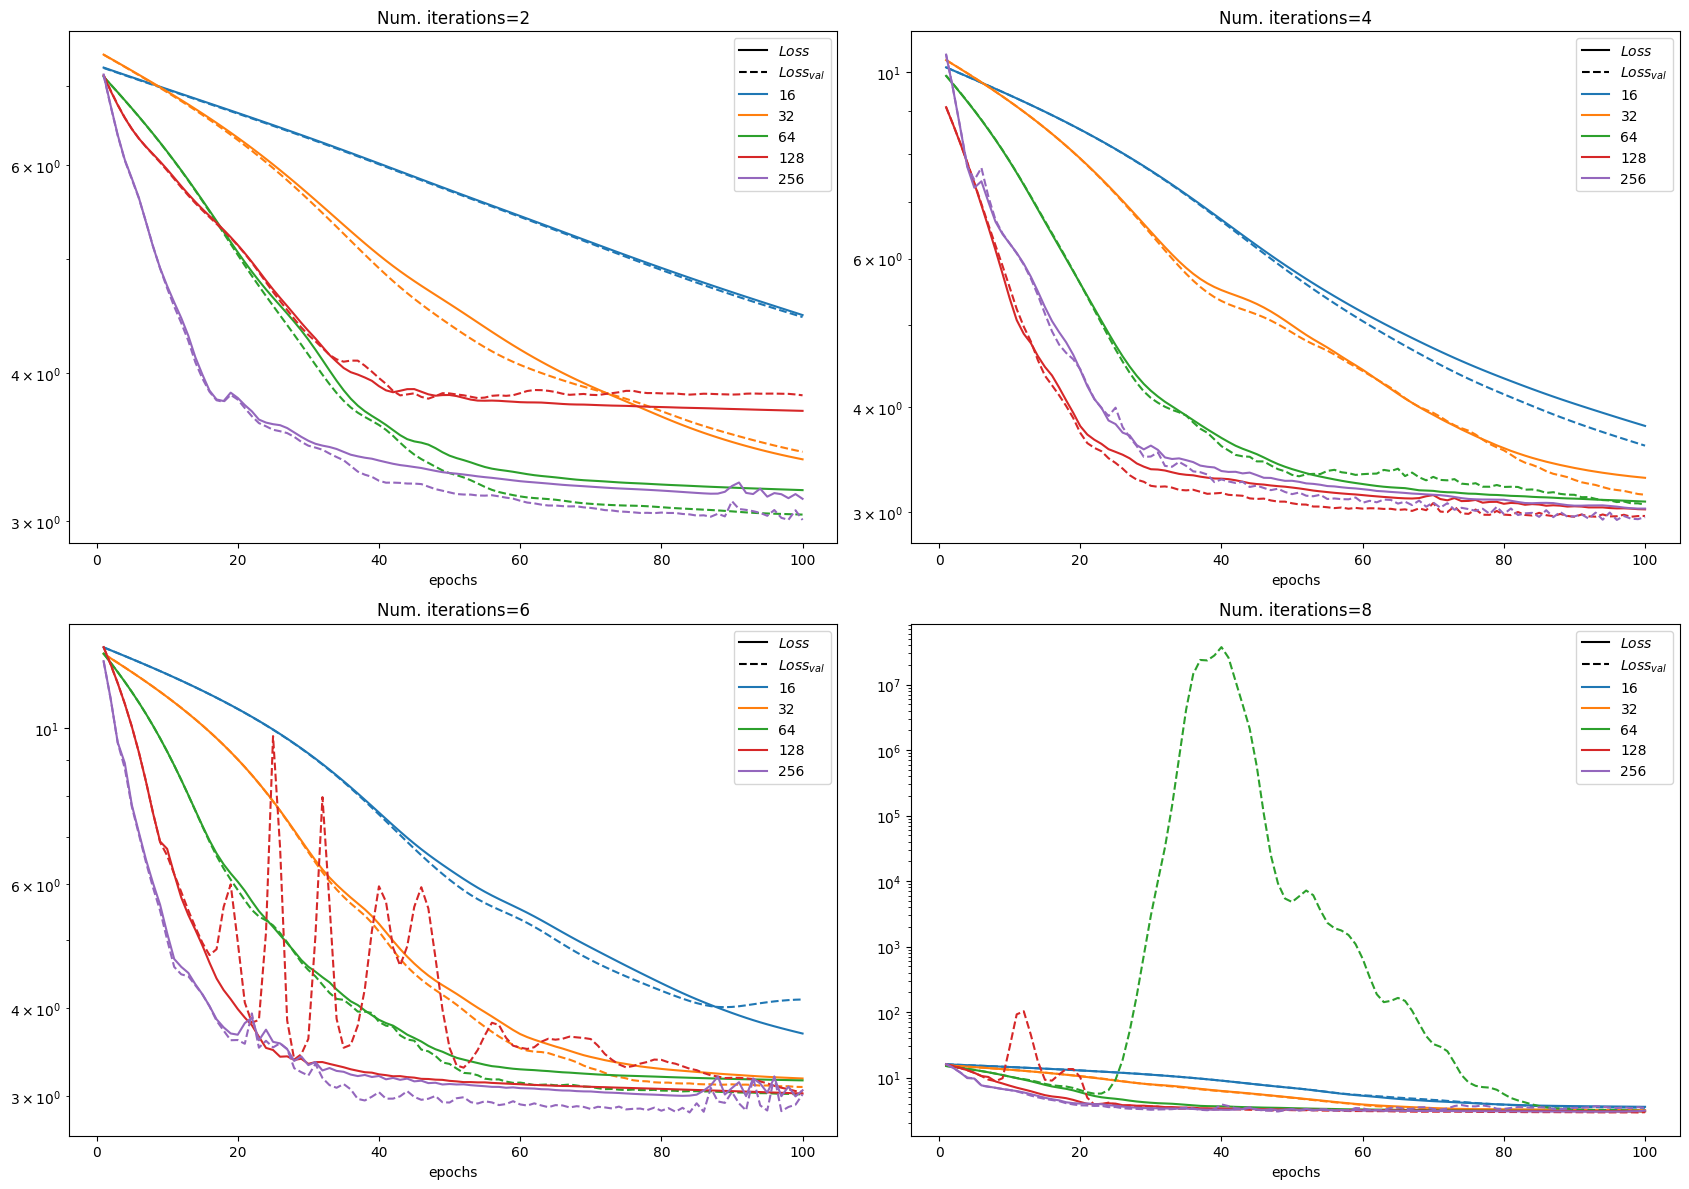

In [36]:

figlosses, axs = plt.subplots(2, 2, figsize=(17, 12))
colors = cm.tab10(np.linspace(0, 1, 10))

for j in range(len(range_iterations)):
  if j<2: axs[0][j].plot(np.NaN, np.NaN,c='k',ls='-',label='$Loss$'), axs[0][j].plot(np.NaN, np.NaN,c='k',ls='--',label='$Loss_{val}$')
  else: axs[1][j-2].plot(np.NaN, np.NaN,c='k',ls='-',label='$Loss$'), axs[1][j-2].plot(np.NaN, np.NaN,c='k',ls='--',label='$Loss_{val}$')
  for h in range(len(range_hidden_features)):
    if j <2:
      axs[0][j].set_title('Num. iterations={}'.format(range_iterations[j]))
      axs[0][j].plot(range(1, epochs + 1), loss_storer[j, h, :], label=range_hidden_features[h], color=colors[h])
      axs[0][j].plot(range(1, epochs + 1), loss_storer_val[j, h, :], ls='--', color=colors[h])
      axs[0][j].set_xlabel('epochs')
      axs[0][j].set_yscale('log')
      axs[0][j].legend()
    else:
       axs[1][j-2].set_title('Num. iterations={}'.format(range_iterations[j]))
       axs[1][j-2].plot(range(1, epochs + 1), loss_storer[j, h, :], label=range_hidden_features[h], color=colors[h])
       axs[1][j-2].plot(range(1, epochs + 1), loss_storer_val[j, h, :], ls='--', color=colors[h])
       axs[1][j-2].set_xlabel('epochs')
       axs[1][j-2].set_yscale('log')
       axs[1][j-2].legend()

figlosses.tight_layout()
plt.show()
figlosses.savefig('figures/Model_optimization.pdf', dpi=190)


In [37]:
flow, optimizer = model_definer(num_features=num_features, num_iterations=6, hidden_features=128)

Num. iterations = 6, Num. hidden_features = 128, Num. trainable parameters = 406320


50 tensor(3.1294, device='cuda:0', grad_fn=<NegBackward0>)
100 tensor(2.9986, device='cuda:0', grad_fn=<NegBackward0>)
150 tensor(2.9285, device='cuda:0', grad_fn=<NegBackward0>)
200 tensor(2.8719, device='cuda:0', grad_fn=<NegBackward0>)
250 tensor(2.8337, device='cuda:0', grad_fn=<NegBackward0>)
300 tensor(2.8111, device='cuda:0', grad_fn=<NegBackward0>)
350 tensor(2.8247, device='cuda:0', grad_fn=<NegBackward0>)
400 tensor(2.8118, device='cuda:0', grad_fn=<NegBackward0>)
450 tensor(2.7779, device='cuda:0', grad_fn=<NegBackward0>)
500 tensor(2.7912, device='cuda:0', grad_fn=<NegBackward0>)
550 tensor(2.7663, device='cuda:0', grad_fn=<NegBackward0>)
600 tensor(2.7647, device='cuda:0', grad_fn=<NegBackward0>)
650 tensor(2.7619, device='cuda:0', grad_fn=<NegBackward0>)
700 tensor(2.7656, device='cuda:0', grad_fn=<NegBackward0>)
750 tensor(2.7735, device='cuda:0', grad_fn=<NegBackward0>)
800 tensor(2.7578, device='cuda:0', grad_fn=<NegBackward0>)
850 tensor(2.7540, device='cuda:0', grad_

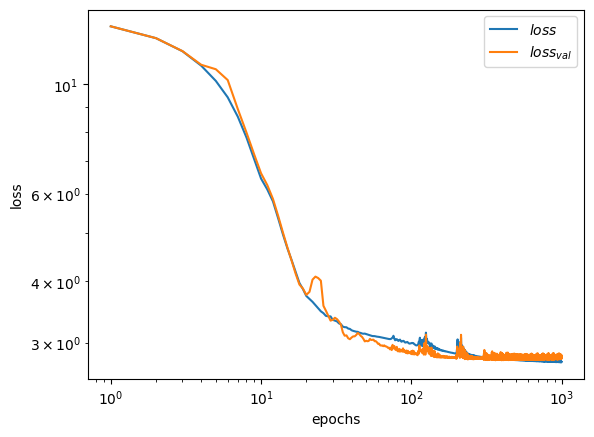

In [38]:
epochs = 1000 #andrà messo a 10000 su colab

figloss=plt.figure()
loss_values = []
loss_validation = []
for i in range(epochs):
  optimizer.zero_grad()
  loss = -flow.log_prob(inputs=xt).mean()
  loss_val = -flow.log_prob(inputs=xval).mean()
  loss.backward()
  optimizer.step()
  loss_values.append(loss.cpu().detach().numpy())
  loss_validation.append(loss_val.cpu().detach().numpy())
  if (i+1) % 50 == 0:
    print(i+1,loss)

plt.plot(range(1, epochs+1), loss_values, label='$loss$')
plt.plot(range(1, epochs+1), loss_validation, label='$loss_{val}$')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()
figloss.savefig('figures/Loss_comparison.pdf',dpi=190)

In [39]:
sample = flow.sample(int(len(x)))
sample = sample.cpu().detach().numpy()
sample = x_preprocessor.backward(sample)

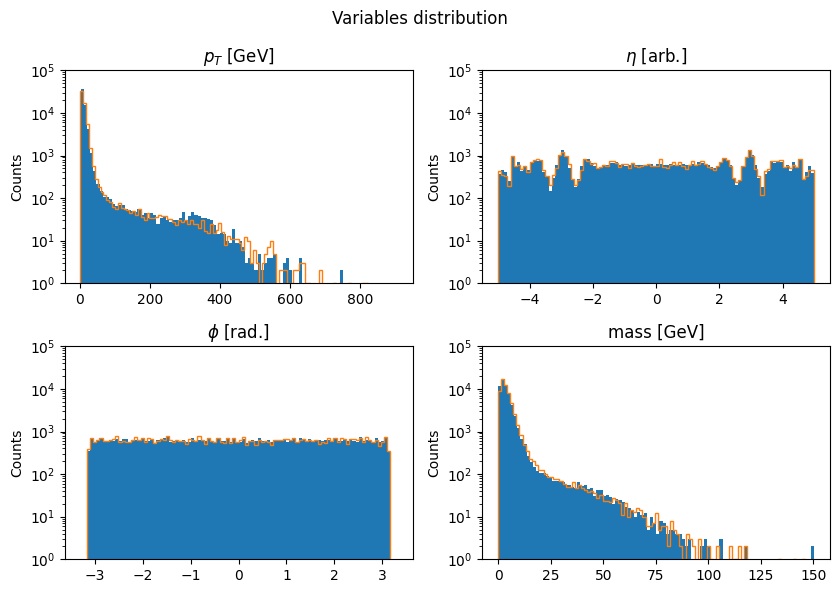

In [40]:
fig,axs = plt.subplots(2, 2,figsize=(8.5,6))
fig.suptitle("Variables distribution")
n_bins = 100

axs[0, 0].hist(x[:,0],bins=n_bins)
axs[0, 0].hist(sample[:,0],bins=n_bins,histtype='step')
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].set_title('{} [GeV]'.format(labels_map[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].set_ylim(1,10e4)

axs[0, 1].hist(x[:,1],bins=n_bins, range=(-5,5))
axs[0, 1].hist(sample[:,1],bins=n_bins, range=(-5,5),histtype='step')
axs[0, 1].set_title('{} [arb.]'.format(labels_map[1]))
axs[0, 1].set_ylim(1,10e4)

axs[1, 0].hist(x[:,2],bins=n_bins, range=(-3.30,3.30))
axs[1, 0].hist(sample[:,2],bins=n_bins, range=(-3.30,3.30),histtype='step')
axs[1, 0].set_title('{} [rad.]'.format(labels_map[2]))
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:,3],bins=n_bins)
axs[1, 1].hist(sample[:,3],bins=n_bins,histtype='step')
axs[1, 1].set_title('{} [GeV]'.format(labels_map[3]))
axs[1,1].sharey(axs[0,0])

for ax in axs.flat:
    ax.set(ylabel='Counts',yscale='log')

fig.tight_layout()

plt.show()
fig.savefig('figures/Variables_distribution_with_reconstruction.pdf',dpi=190)

In [41]:
#training
# gaus = flow(data)
# unif = erf(gaus)
# unif' = unif * 2**N
# unif'' = int(unif')
# comp = unif''/2**N
# gaus' = erfinv(comp)
# data' = flow^-1(gaus') ==? data

In [42]:
###COMPRESSING###
x_compressor = Compressor(flow=flow, N=11, limit=3)
x_compressed = x_compressor.compress(xt)
x_decompressed = x_compressor.decompress(x_compressed)
x_decompressed = x_preprocessor.backward(x_decompressed)

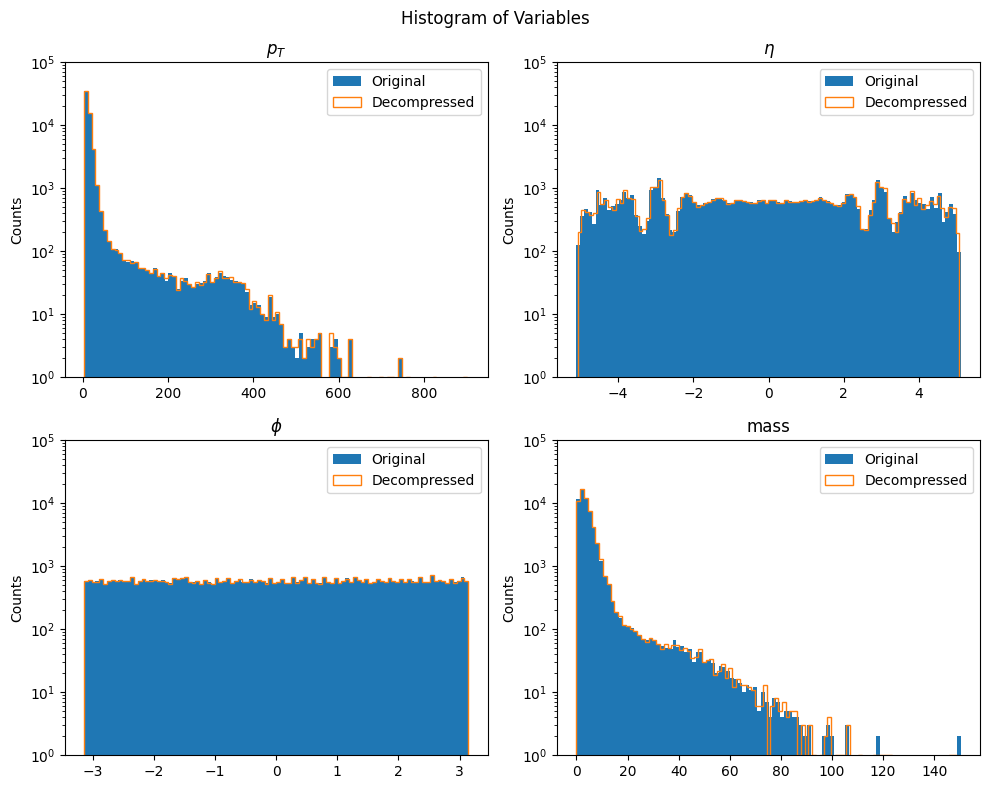

In [43]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Histogram of Variables")

n_bins = 100

axs[0, 0].hist(x[:, 0], bins=n_bins, label='Original',  log=True)
axs[0, 0].hist(x_decompressed[:, 0], bins=n_bins, label='Decompressed',histtype='step')
axs[0, 0].set_title(labels_map[0])
axs[0, 0].set_ylabel("Counts")
axs[0, 0].set_ylim(1,10e4)
axs[0, 0].legend()

axs[0, 1].hist(x[:, 1], bins=n_bins, label='Original', log=True)
axs[0, 1].hist(x_decompressed[:, 1], bins=n_bins, label='Decompressed',histtype='step')
axs[0, 1].set_title(labels_map[1])
axs[0, 1].set_ylabel("Counts")
axs[0, 1].set_ylim(1,10e4)
axs[0, 1].legend()

axs[1, 0].hist(x[:, 2], bins=n_bins, label='Original', log=True)
axs[1, 0].hist(x_decompressed[:, 2], bins=n_bins, label='Decompressed',histtype='step')
axs[1, 0].set_title(labels_map[2])
axs[1, 0].set_ylabel("Counts")
axs[1, 0].legend()
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:, 3], bins=n_bins, label='Original', log=True)
axs[1, 1].hist(x_decompressed[:, 3], bins=n_bins, label='Decompressed', histtype='step')
axs[1, 1].set_title(labels_map[3])
axs[1, 1].set_ylabel("Counts")
axs[1, 1].legend()
axs[1,1].sharey(axs[0,0])

plt.tight_layout()
plt.show()
fig.savefig('figures/Variables_comparison.pdf', dpi=190)


<ipython-input-44-db81f2e4f18b>:22: RuntimeWarning: divide by zero encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)
<ipython-input-44-db81f2e4f18b>:22: RuntimeWarning: invalid value encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)


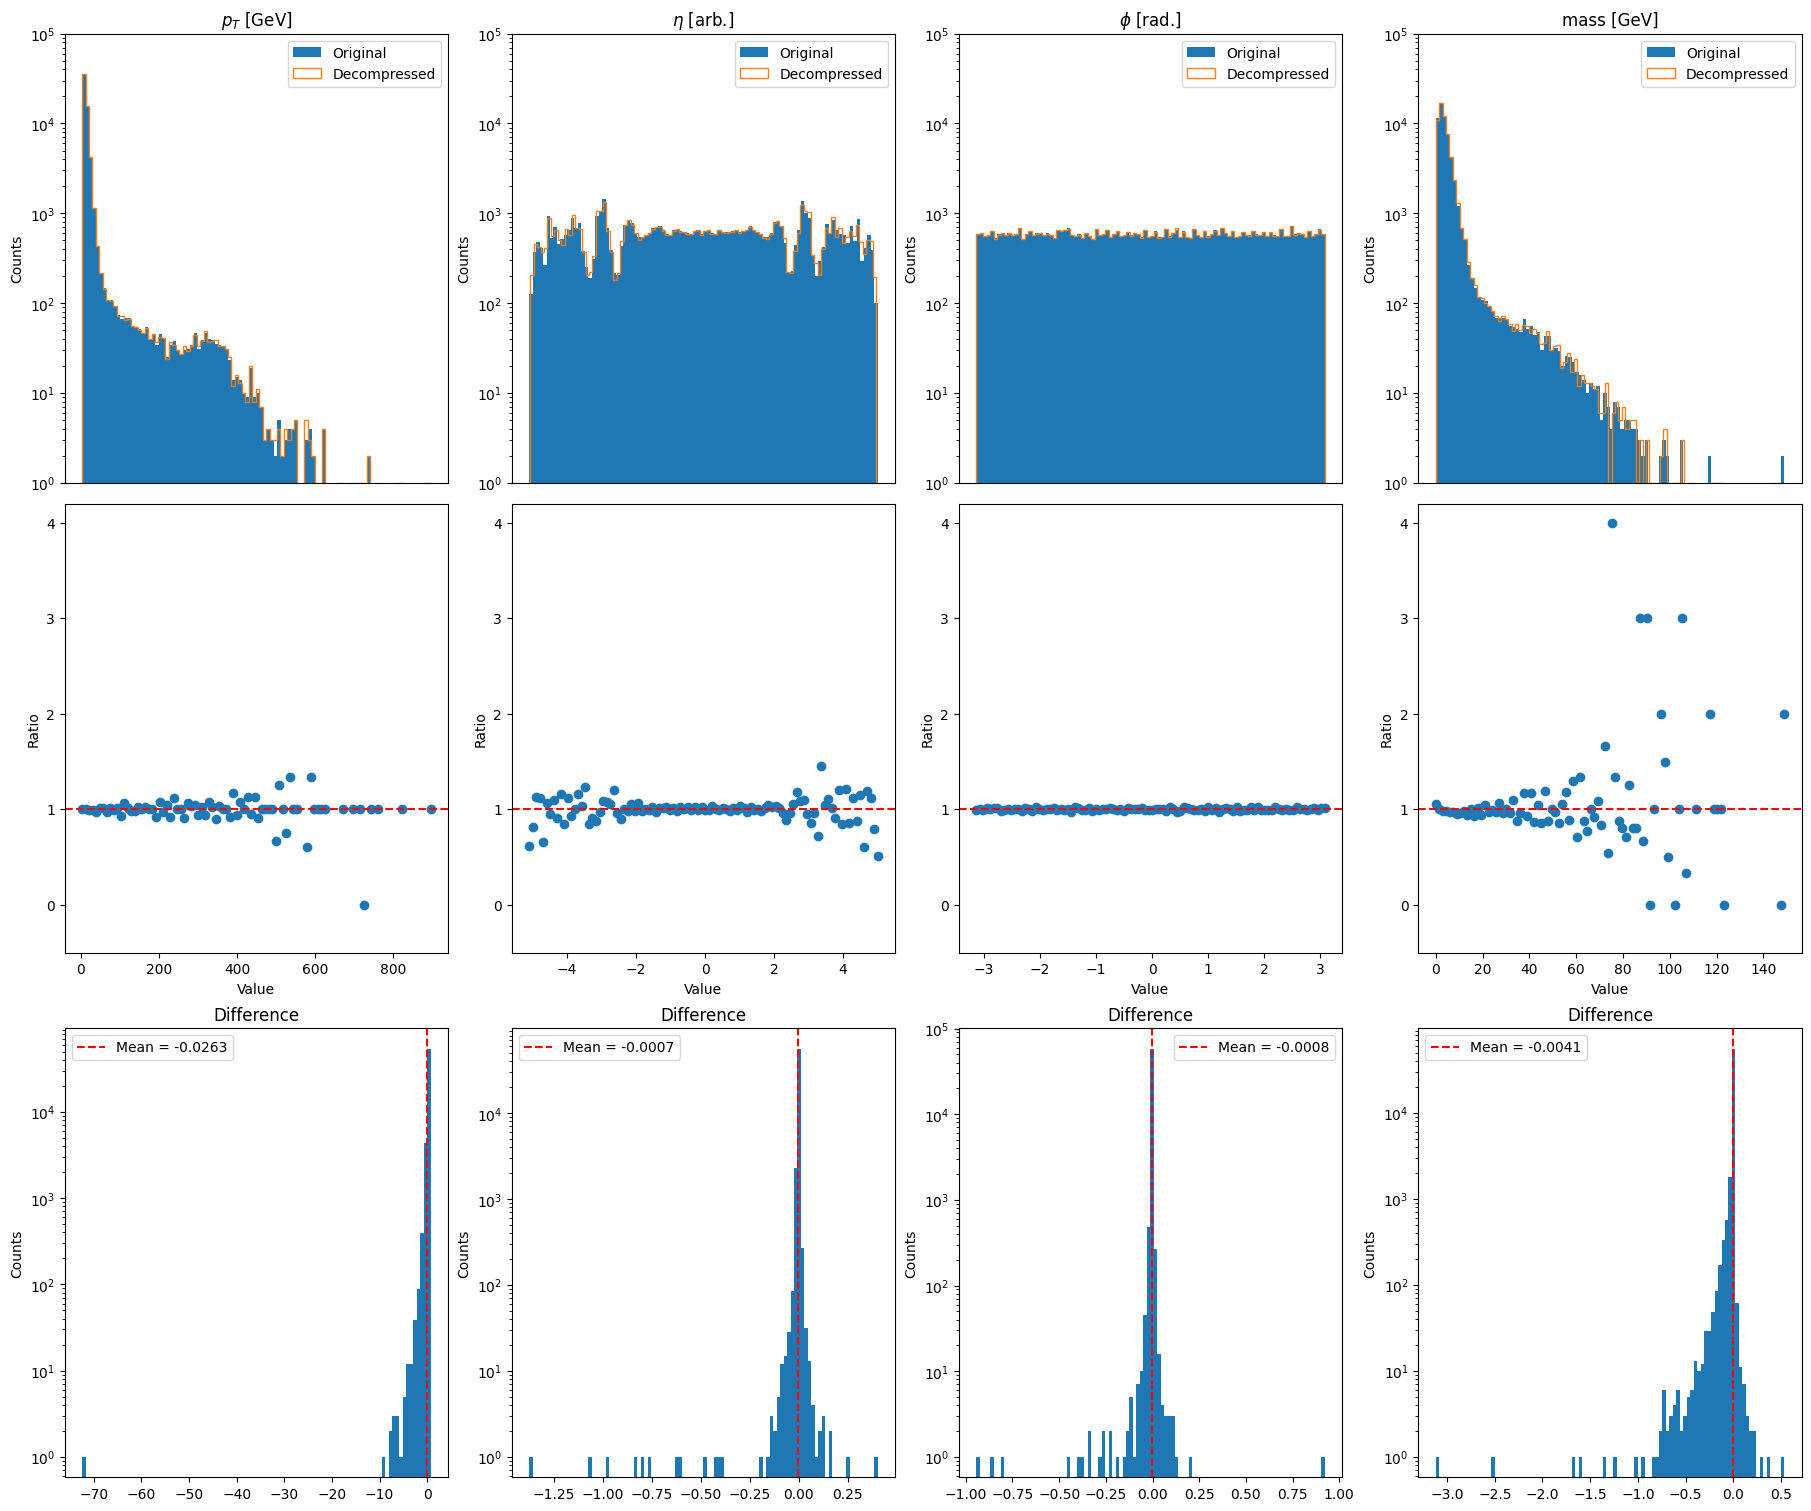

In [44]:
difference = x_decompressed-x

fig_diff, axs = plt.subplots(3, 4, figsize=(18, 15), layout='constrained')
fig.suptitle("Histogram and Ratio Plots")

n_bins = 100

for i in range(4):
    y = []
    y.append(x[:, i])
    y.append(x_decompressed[:, i])

    ns, bins, patches = axs[0, i].hist(y[0], bins=n_bins, label='Original', log=True)
    ns1,bins1,patches1 = axs[0, i].hist(y[1], bins=n_bins, label='Decompressed', histtype='step')
    axs[0, i].set_title('{} [{}]'.format(labels_map[i],unit_measure[i]))
    axs[0, i].set_ylabel("Counts")
    axs[0, i].legend()
    axs[0, i].set_ylim(1,10e4)
    axs[0, i].get_xaxis().set_ticks([])


    axs[1, i].scatter(bins[:-1],ns/ns1)
    axs[1, i].axhline(y=1, color='r', linestyle='--')
    axs[1, i].set_xlabel("Value")
    axs[1, i].set_ylabel("Ratio")
    axs[1, i].set_ylim(-0.5,4.2)


    axs[2, i].hist(difference[:, i],bins = n_bins,log=True)
    axs[2, i].set_title("Difference")
    axs[2, i].set_ylabel("Counts")
    axs[2, i].axvline(x=np.mean(difference[:, i]), color='r', linestyle='--',label='Mean = {:.4f}'.format(np.mean(difference[:, i])))
    axs[2, i].legend()

plt.show()
fig_diff.savefig('figures/difference.pdf', dpi=190)

In [45]:
with open('input.txt', 'w') as input:
    for i in range(len(x)):
        input.write(' '.join(str(x[i, j]) for j in range(x.shape[1])) + "\n")

with open('output.txt', 'w') as output:
    for i in range(len(x)):
        output.write(' '.join(str(x_decompressed[i, j]) for j in range(x_decompressed.shape[1])) + "\n")

with open('compressed.txt', 'w') as compressed:
    for i in range(len(x)):
        compressed.write(' '.join(str(x_compressed[i, j]) for j in range(x_compressed.shape[1])) + "\n")


In [46]:
size_input = stat('input.txt').st_size
print('Size of input file =',size_input/(1024*1024),'MB')

size_output = stat('output.txt').st_size
print('Size of output file =',size_output/(1024*1024),'MB')

size_compressed = stat('compressed.txt').st_size
print('Size of compressed file =',size_compressed/(1024*1024),'MB')

print('Compression ratio =',size_input/size_compressed)

Size of input file = 3.2242536544799805 MB
Size of output file = 2.2703771591186523 MB
Size of compressed file = 1.1052303314208984 MB
Compression ratio = 2.9172685211550773


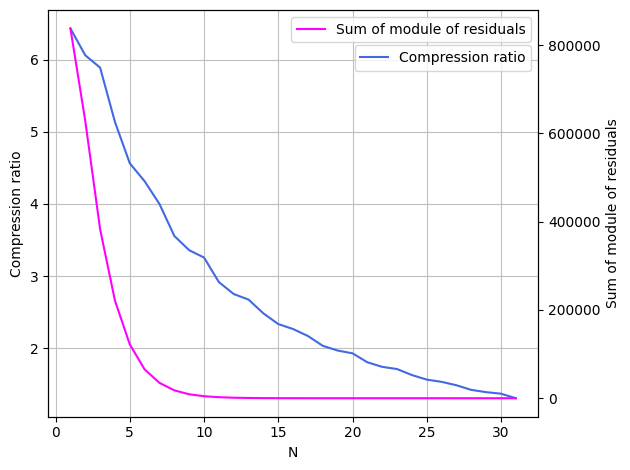

In [47]:
RR = []
residui = []


for k in range(1,32):
    x_compressor_k = Compressor(flow=flow, N=k, limit=3)
    x_compressed_k = x_compressor_k.compress(xt)
    x_decompressed_k = x_compressor_k.decompress(x_compressed_k)
    x_decompressed_k = x_preprocessor.backward(x_decompressed_k)

    with open('output_k.txt', 'w') as output:
        for i in range(len(x)):
            output.write(' '.join(str(x_decompressed_k[i, j]) for j in range(x_decompressed_k.shape[1])) + "\n")

    with open('compressed_k.txt', 'w') as compressed:
        for i in range(len(x)):
            compressed.write(' '.join(str(x_compressed_k[i, j]) for j in range(x_compressed_k.shape[1])) + "\n")

    size_output_k = stat('output_k.txt').st_size
    size_compressed_k = stat('compressed_k.txt').st_size

    r_k = size_input/size_compressed_k
    RR.append(r_k)

    residui_k = np.sum(np.abs(x-x_decompressed_k))
    residui.append(residui_k)


fig, ax1 = plt.subplots()
ax1.set_xlabel('N')
ax1.set_ylabel('Compression ratio')
ax1.plot(range(1,k+1),RR, c='royalblue',label='Compression ratio')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Sum of module of residuals')
ax2.plot(range(1,k+1),residui, c='fuchsia',label='Sum of module of residuals')
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.93))
ax2.legend(loc=0)
ax1.grid(c='silver')
plt.show()

fig.savefig('figures/Compression_ratio.pdf',dpi=190)

In [48]:
###TESTING

xtest_preprocessor = Preprocessor(preprocessor_settings)
xtest_preprocessed = xtest_preprocessor.forward(xtest)
xtest_compressed = x_compressor.compress(xtest_preprocessed)
xtest_decompressed = x_compressor.decompress(xtest_compressed)
xtest_decompressed = xtest_preprocessor.backward(xtest_decompressed)

with open('test_input.txt', 'w') as test_input:
    for i in range(len(xtest)):
        test_input.write(' '.join(str(xtest[i, j]) for j in range(xtest.shape[1])) + "\n")

with open('test_compressed.txt', 'w') as test_compressed:
        for i in range(len(xtest)):
            test_compressed.write(' '.join(str(xtest_compressed[i, j]) for j in range(xtest_compressed.shape[1])) + "\n")

size_test_input = stat('test_input.txt').st_size
size_test_compressed = stat('test_compressed.txt').st_size
r_test = size_test_input/size_test_compressed
print('Compression ratio for test =',r_test)

Compression ratio for test = 3.054839480889723


<ipython-input-49-e5af39f7e932>:22: RuntimeWarning: divide by zero encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)
<ipython-input-49-e5af39f7e932>:22: RuntimeWarning: invalid value encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)


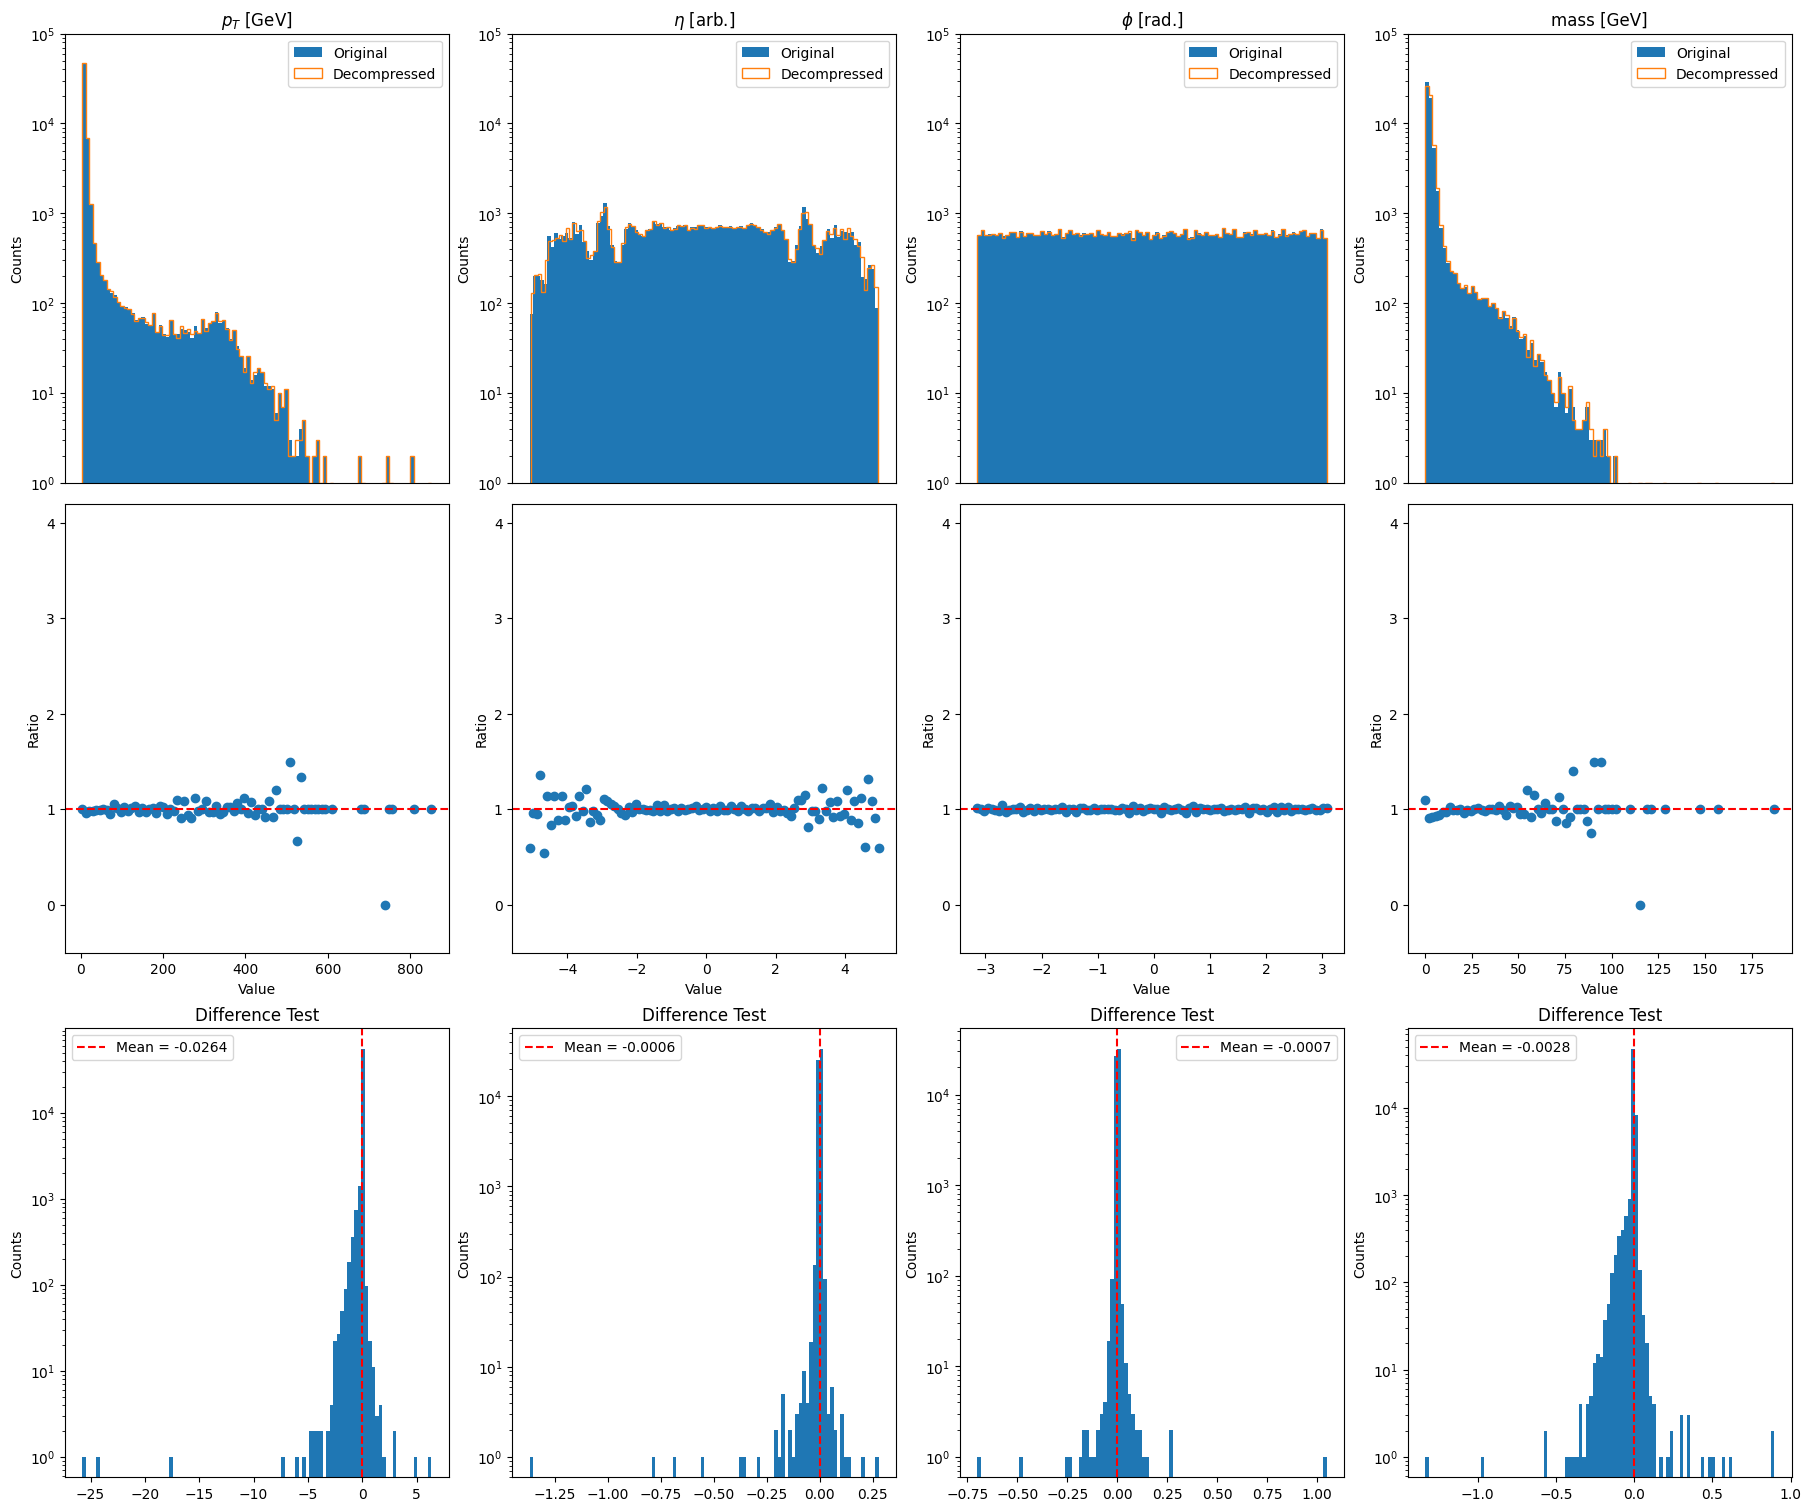

In [49]:
difference_test = xtest_decompressed-xtest

fig_diff, axs = plt.subplots(3, 4, figsize=(18, 15), layout='constrained')
fig.suptitle("Histogram and Ratio Plots for Test")

n_bins = 100

for i in range(4):
    y = []
    y.append(xtest[:, i])
    y.append(xtest_decompressed[:, i])

    ns, bins, patches = axs[0, i].hist(y[0], bins=n_bins, label='Original', log=True)
    ns1,bins1,patches1 = axs[0, i].hist(y[1], bins=n_bins, label='Decompressed', histtype='step')
    axs[0, i].set_title('{} [{}]'.format(labels_map[i],unit_measure[i]))
    axs[0, i].set_ylabel("Counts")
    axs[0, i].legend()
    axs[0, i].set_ylim(1,10e4)
    axs[0, i].get_xaxis().set_ticks([])


    axs[1, i].scatter(bins[:-1],ns/ns1)
    axs[1, i].axhline(y=1, color='r', linestyle='--')
    axs[1, i].set_xlabel("Value")
    axs[1, i].set_ylabel("Ratio")
    axs[1, i].set_ylim(-0.5,4.2)


    axs[2, i].hist(difference_test[:, i],bins = n_bins,log=True)
    axs[2, i].set_title("Difference Test")
    axs[2, i].set_ylabel("Counts")
    axs[2, i].axvline(x=np.mean(difference_test[:, i]), color='r', linestyle='--',label='Mean = {:.4f}'.format(np.mean(difference_test[:, i])))
    axs[2, i].legend()

plt.show()
fig_diff.savefig('figures/difference_test.pdf', dpi=190)